In [2]:
bucket = 'ashwathbucket'
prefix = 'Graduate admission'

import sagemaker

role = sagemaker.get_execution_role()

In [3]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image                 
from IPython.display import display               
from sklearn.datasets import dump_svmlight_file   
from time import gmtime, strftime  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import sys                                        
import math                                       
import json
import boto3

In [11]:
raw_data_filename = 'Admission_Predict_Ver1.1.csv'

s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file(prefix + '/' + raw_data_filename, 'raw_data.csv')

data = pd.read_csv('./raw_data.csv')
pd.set_option('display.max_rows', 20) 
#removing white spaces 
data.rename(columns=lambda x: x.strip(), inplace=True)
data.drop(columns = {'Serial No.'}, inplace = True)
data

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
5,330,115,5,4.5,3.0,9.34,1,0.90
6,321,109,3,3.0,4.0,8.20,1,0.75
7,308,101,2,3.0,4.0,7.90,0,0.68
8,302,102,1,2.0,1.5,8.00,0,0.50
9,323,108,3,3.5,3.0,8.60,0,0.45


In [34]:
data.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


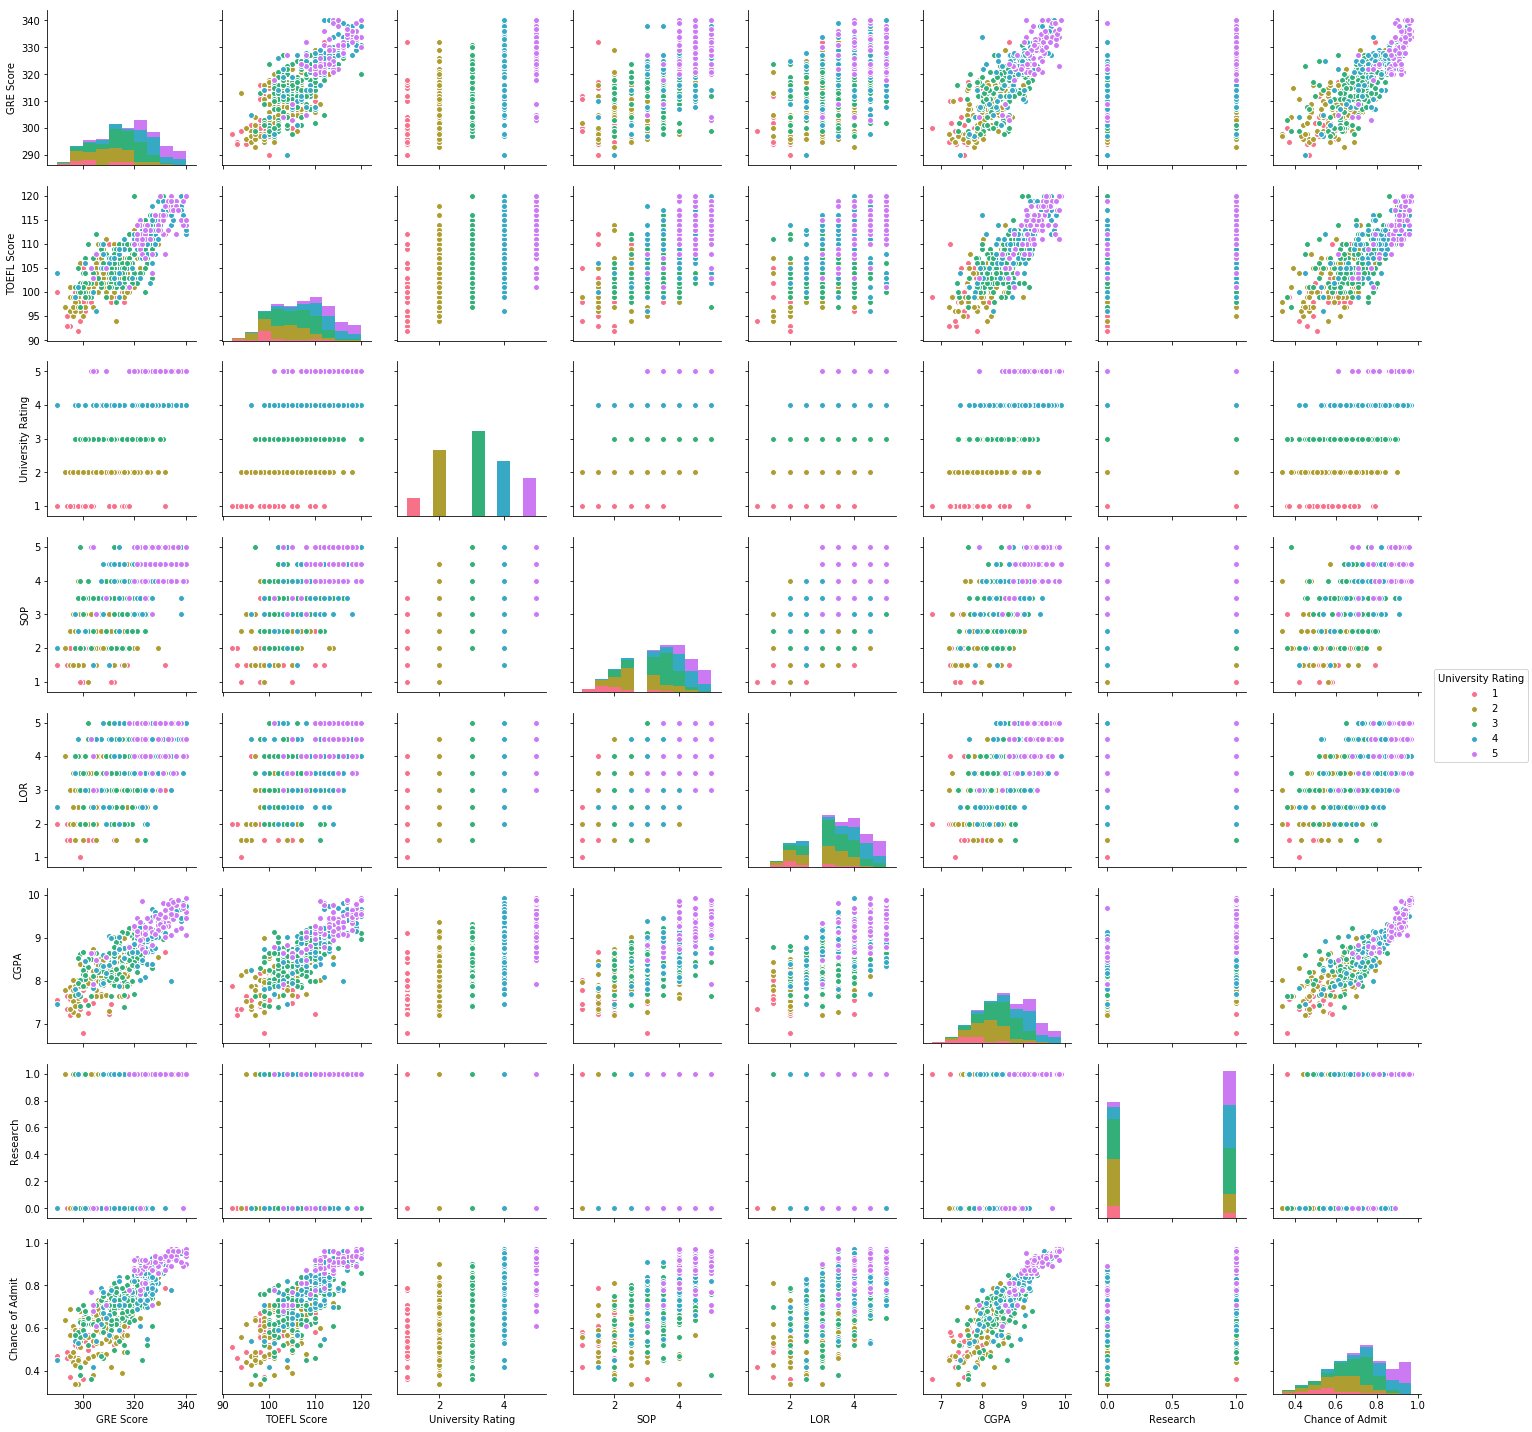

In [38]:
sns.pairplot(data, kind='scatter', hue='University Rating', palette='husl')

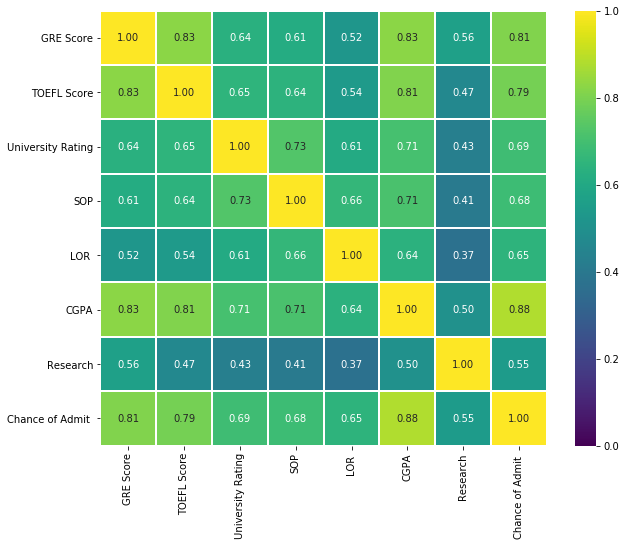

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data.corr(), ax=ax, annot=True, linewidths=1, fmt='.2f',
            cmap="viridis", vmin=0, vmax=1)
plt.show()

In [40]:
data.corr()['Chance of Admit '].round(1)

GRE Score            0.8
TOEFL Score          0.8
University Rating    0.7
SOP                  0.7
LOR                  0.6
CGPA                 0.9
Research             0.5
Chance of Admit      1.0
Name: Chance of Admit , dtype: float64

In [12]:
data['Chance of Admit'].mean()

0.7217399999999996

In [34]:
outcome = np.where(data['Chance of Admit'] >= data['Chance of Admit'].median() , 1 ,0 )
outcome.shape

KeyError: 'Chance of Admit'

In [24]:
data['Outcome'] = outcome
#data.drop(['Chance of Admit'],axis = 1, inplace = True)
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Outcome
0,337,118,4,4.5,4.5,9.65,1,1
1,324,107,4,4.0,4.5,8.87,1,1
2,316,104,3,3.0,3.5,8.00,1,1
3,322,110,3,3.5,2.5,8.67,1,1
4,314,103,2,2.0,3.0,8.21,0,0


In [27]:
outcome.sum()/len(outcome) 

0.528

In [29]:
loc = data.iloc[:,:-1]

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0
5,330,115,5,4.5,3.0,9.34,1
6,321,109,3,3.0,4.0,8.20,1
7,308,101,2,3.0,4.0,7.90,0
8,302,102,1,2.0,1.5,8.00,0
9,323,108,3,3.5,3.0,8.60,0


In [30]:
x_train, x_test, y_train, y_test = train_test_split(loc, outcome, test_size=.2, shuffle=True, random_state=20)

In [32]:
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
#test data score
log_reg.score(x_test,y_test)

0.82